# Porosity

In [5]:
import pandas as pd

porosity_df = pd.read_csv('linear_dependency.csv')

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

import numpy as np

In [9]:
x = porosity_df['d_param'].values.reshape(-1,1)
y = porosity_df['porosity_Schwarz_p'].values

x_train, y_train, x_test, y_test = train_test_split(x, y)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((15, 1), (5, 1), (15,), (5,))

In [17]:
degree = 3

x_poly = PolynomialFeatures(degree=degree).fit_transform(x)
print(x_poly.shape)
linear = LinearRegression()
linear.fit(x_poly, y)
y_pred = linear.predict(x_poly)
mse(y, y_pred)
print(linear.coef_)

(20, 4)
[ 0.         -0.06816784  0.04984266  0.01013945]


In [18]:
import matplotlib.pyplot as plt

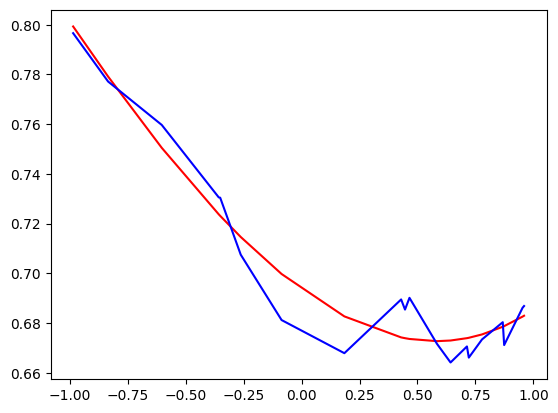

In [19]:
plt.plot(x, y_pred, c='red')
plt.plot(x, y, c='blue')

# Entropy

In [89]:
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

import numpy as np

entropy_df = pd.read_csv('entropy.csv')

- Schwarz:

        1-entropy is nice: `degree=3` or `degree=4`
        2-entropy is bad.
- Gyroid:

        1-entropy is nice: `degree 2,3,4`
        2-entropy is bad too

In [ ]:
x_train, y_train, x_test, y_test = train_test_split(x, y)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

## Polynomial

In [86]:
class PolynomialModel:
    def __init__(self, data, degree=4, test_size=0.33, random_state=42, round_for_poly=0.01):
        self.y = data['y']
        self.X = data['x']
        self.degree = degree
        self.model = Pipeline([('features', PolynomialFeatures(degree=degree)), 
                               ('linear', LinearRegression())])
        self.test_size = test_size
        self.random_state = random_state
        self.round_for_poly = round_for_poly

    def fit(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, 
                                                            self.y, test_size=self.test_size, 
                                                            random_state=self.random_state)
        self.model.fit(X_train, y_train)
        r_2_test = self.model.score(X_test, y_test)
        r_2_train = self.model.score(X_train, y_train)
        y_pred = self.model.predict(X_test)
        y_hat = self.model.predict(X_train)
        mse_test = mean_squared_error(y_test, y_pred)
        mse_train = mean_squared_error(y_train, y_hat)
        return {"r2_test": r_2_test, "r2_train": r_2_train, "mse_test": mse_test, "mse_train": mse_train}
    
    def return_formula(self):
        variables = self.model['features'].get_feature_names_out(['x']).tolist()
        coeffs = self.model['linear'].coef_
        coeffs_str = list(map(lambda x: str(round(x,2)), coeffs))
        polynomial = " + ".join([coef + var for coef, var in 
                                 zip(coeffs_str, variables) if np.abs(float(coef)) > self.round_for_poly])
        return f"{self.model['linear'].intercept_:.2f} + " + polynomial

In [107]:
class Experiments():
    def __init__(self, model_class, data):
        self.model_class = model_class
        self.data = data

    def run_experiments(self, degrees = range(1,10), *args, **kwargs):
        self.results = {}
        for deg in degrees:
            self.model = self.model_class(data = self.data, degree=deg, *args, **kwargs)
            experiment_results = self.model.fit()
            self.results[deg] = experiment_results
        self.results_df = pd.DataFrame(self.results).T
        self.results_df = self.results_df.reset_index().rename(columns={"index":"degree"})

        return self.results_df

<Axes: title={'center': 'Gyroid'}, xlabel='degree', ylabel='MSE'>

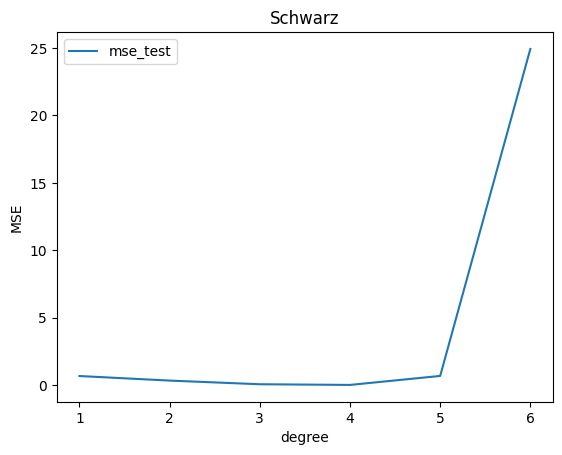

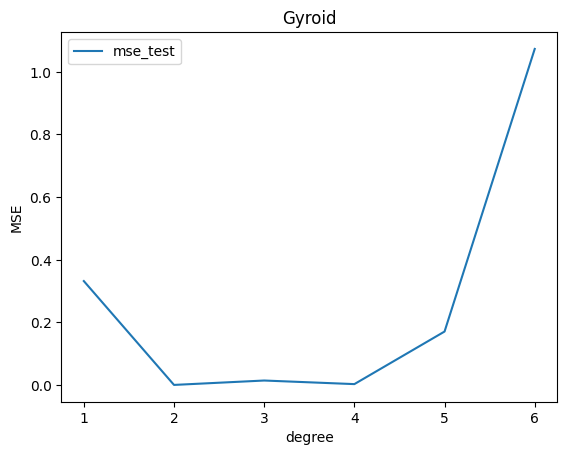

In [113]:
schwarz_polynomial_experiments = Experiments(PolynomialModel, data_schwarz)
_ = schwarz_polynomial_experiments.run_experiments(degrees=range(1,7))
schwarz_polynomial_experiments.results_df.plot("degree", "mse_test", ylabel='MSE', title="Schwarz")

gyroid_polynomial_experiments = Experiments(PolynomialModel, data_gyroid)
_ = gyroid_polynomial_experiments.run_experiments(degrees=range(1,7))
gyroid_polynomial_experiments.results_df.plot("degree", "mse_test", ylabel='MSE', title="Gyroid")

   degree   r2_test  r2_train   mse_test  mse_train
0       1  0.914083  0.994179   0.673468   0.014675
1       2  0.957247  0.997682   0.335126   0.005843
2       3  0.991910  0.999020   0.063417   0.002472
3       4  0.998288  0.999370   0.013422   0.001589
4       5  0.913245  0.999550   0.680037   0.001135
5       6 -2.181057  0.999969  24.934983   0.000079
6       7 -1.468954  0.999969  19.353108   0.000078


<Axes: xlabel='degree', ylabel='MSE'>

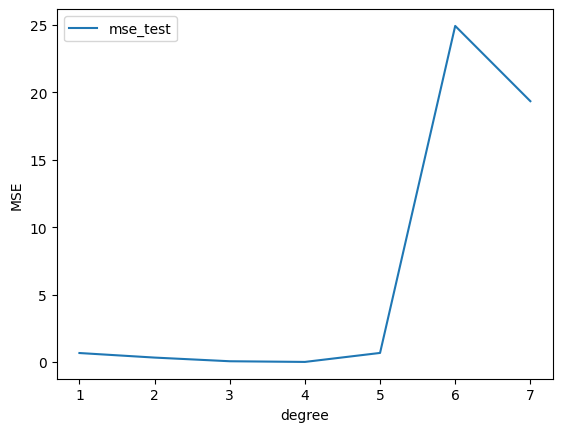

In [41]:
x = entropy_df['d_param'].values.reshape(-1,1)
data_schwarz = {'x': x, 'y': entropy_df['Schwarz'].values}
data_gyroid = {'x':x, 'y': entropy_df['Gyroid'].values}

degree_metrics_table_schwarz = {}

def fit_polynomial(deg, tpms_type):
    x = entropy_df['d_param'].values.reshape(-1,1)
    data = {'x':x, 'y': entropy_df[tpms_type].values}
    polynomial_model = PolynomialModel(data, degree=deg)
    return polynomial_model.fit()

def eval_polynomial(deg, tpms_type):
    results = {}
    for tpms_type in ['Schwarz', 'Gyroid']:
        results[tpms_type] = fit_polynomial(deg, tpms_type)
    return results  

for d in range(1, 8):
    degree_metrics_table_schwarz[d] = fit_polynomial(d, 'Schwarz')

degree_mse_df_schwarz = pd.DataFrame(degree_metrics_table_schwarz).T
degree_mse_df_schwarz = degree_mse_df_schwarz.reset_index().rename(columns={"index":"degree"})
print(degree_mse_df_schwarz)
degree_mse_df_schwarz.plot("degree", "mse_test", ylabel='MSE')

   degree   r2_test  r2_train  mse_test  mse_train
0       1 -2.295738  0.535349  0.332103   0.049893
1       2  0.994298  0.994566  0.000575   0.000583
2       3  0.854918  0.997654  0.014620   0.000252
3       4  0.968623  0.997930  0.003162   0.000222
4       5 -0.696891  0.999726  0.170991   0.000029
5       6 -9.650042  0.999945  1.073177   0.000006
6       7  0.964201  0.999976  0.003607   0.000003


<Axes: xlabel='degree', ylabel='MSE'>

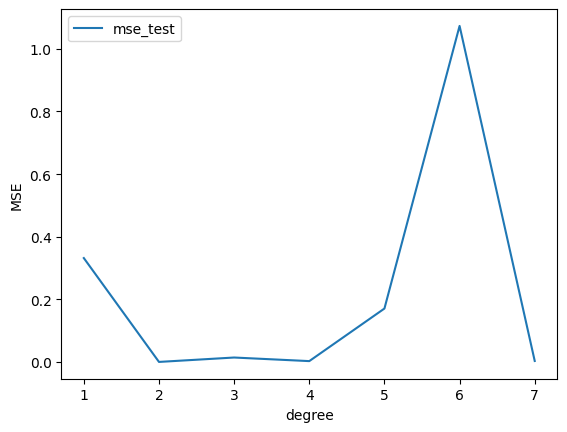

In [32]:
degree_metrics_table_gyroid = {}

for d in range(1, 8):
    degree_metrics_table_gyroid[d] = fit_polynomial(d, 'Gyroid')

degree_mse_df_gyroid = pd.DataFrame(degree_metrics_table_gyroid).T
degree_mse_df_gyroid = degree_mse_df_gyroid.reset_index().rename(columns={"index":"degree"})
print(degree_mse_df_gyroid)
degree_mse_df_gyroid.plot("degree", "mse_test", ylabel='MSE')

<Axes: xlabel='degree', ylabel='MSE'>

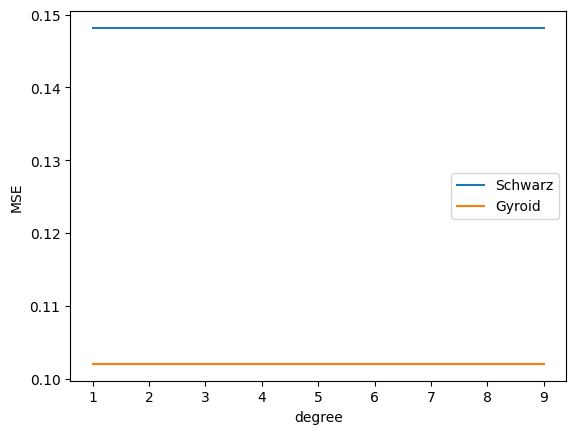

In [44]:
degree_mse_table = {}

def fit_polynomial(deg, tpms_type):
    x = entropy_df['d_param'].values.reshape(-1,1)
    x_poly = PolynomialFeatures(degree=deg).fit_transform(x)
    y = entropy_df[tpms_type].values
    linear = LinearRegression()
    linear.fit(x_poly, y)
    y_pred = linear.predict(x_poly)
    return mse(y, y_pred)

def eval_polynomial(deg):
    results = {}
    for tpms_type in ['Schwarz', 'Gyroid']:
        results[tpms_type] = fit_polynomial(deg, tpms_type)
    return results  

for d in range(1, 10):
    degree_mse_table[d] = eval_polynomial(d)

degree_mse_df = pd.DataFrame(degree_mse_table).T
degree_mse_df = degree_mse_df.reset_index().rename(columns={"index":"degree"})
degree_mse_df.plot("degree", ylabel='MSE')

In [33]:
degree = 4

x = entropy_df['d_param'].values.reshape(-1,1)
x_poly = PolynomialFeatures(degree=degree).fit_transform(x)
y_schwarz = entropy_df['Schwarz'].values

linear = LinearRegression()
linear.fit(x_poly, y_schwarz)
y_pred = linear.predict(x_poly)
mse(y_schwarz, y_pred)
print(f"coefficients are {linear.coef_}, {linear.intercept_}")

coefficients are [ 0.         -2.90274704  0.47419456 -1.09516654  0.72459268], 7.74234110934714


In [58]:
for deg in range(1,10):
    poly_schwarz = PolynomialModel(data_schwarz, degree=deg)
    metrics = poly_schwarz.fit()
    print(f"MSE = {metrics['mse_test']:.3f}", "\t", poly_schwarz.return_polynomial())

MSE = 0.673 	 7.88 + -3.05x
MSE = 0.335 	 7.77 + -3.25x + 0.46x^2
MSE = 0.063 	 7.70 + -3.06x + 0.88x^2 + -0.63x^3
MSE = 0.013 	 7.74 + -2.88x + 0.52x^2 + -1.25x^3 + 0.82x^4
MSE = 0.680 	 7.78 + -2.95x + -0.18x^2 + -0.49x^3 + 2.42x^4 + -1.69x^5
MSE = 24.935 	 7.79 + -3.51x + -0.29x^2 + 5.02x^3 + -0.46x^4 + -12.44x^5 + 8.91x^6
MSE = 19.353 	 7.79 + -3.48x + -0.38x^2 + 4.81x^3 + 0.36x^4 + -12.39x^5 + 7.33x^6 + 1.0x^7
MSE = 4923.961 	 7.73 + -3.83x + 5.14x^2 + 1.85x^3 + -46.77x^4 + 57.18x^5 + 68.43x^6 + -161.33x^7 + 76.8x^8
MSE = 3405.392 	 7.73 + -3.82x + 4.82x^2 + 2.75x^3 + -44.82x^4 + 47.36x^5 + 74.61x^6 + -144.99x^7 + 51.42x^8 + 10.13x^9


In [59]:
for deg in range(1,10):
    poly_gyroid = PolynomialModel(data_gyroid, degree=deg)
    metrics = poly_gyroid.fit()
    print(f"MSE = {metrics['mse_test']:.3f}", "\t", poly_gyroid.return_polynomial())

MSE = 0.332 	 8.58 + -0.46x
MSE = 0.001 	 8.84 + -1.08x^2
MSE = 0.015 	 8.86 + -0.05x + -1.22x^2 + 0.2x^3
MSE = 0.003 	 8.87 + -0.02x + -1.28x^2 + 0.09x^3 + 0.15x^4
MSE = 0.171 	 8.89 + -0.07x + -1.74x^2 + 0.58x^3 + 1.2x^4 + -1.1x^5
MSE = 1.073 	 8.90 + -0.15x + -1.75x^2 + 1.4x^3 + 0.77x^4 + -2.71x^5 + 1.33x^6
MSE = 0.004 	 8.90 + -0.11x + -1.91x^2 + 1.05x^3 + 2.14x^4 + -2.62x^5 + -1.32x^6 + 1.67x^7
MSE = 62.564 	 8.91 + -0.07x + -2.57x^2 + 1.41x^3 + 7.83x^4 + -11.02x^5 + -8.7x^6 + 21.27x^7 + -9.27x^8
MSE = 116.110 	 8.91 + -0.07x + -2.65x^2 + 1.63x^3 + 8.3x^4 + -13.4x^5 + -7.2x^6 + 25.23x^7 + -15.43x^8 + 2.46x^9


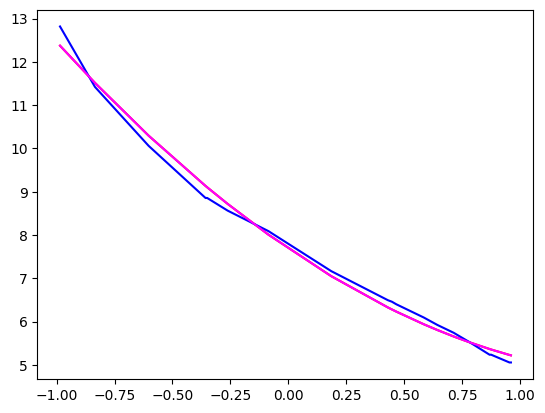

In [116]:
coefs = linear.coef_
y_range = -3.65061491 * x + 1.12689025 * x**2 + 7.684316640578228
#np.dot(coefs[::-1], [x[:,0]**(i+1) for i in range(3)]) + 7.684316640578228

plt.plot(x, y_pred, c='red')
plt.plot(x, y_schwarz, c='blue')
plt.plot(x, y_range, c="magenta")

In [121]:
y_gyroid = entropy_df['Gyroid'].values

linear = LinearRegression()
linear.fit(x_poly, y_gyroid)
y_pred = linear.predict(x_poly)
mse(y_gyroid, y_pred)

0.00047788342399690726

In [123]:
print(f"coefficients are {linear.coef_}, {linear.intercept_}")

coefficients are [ 0.         -0.00918911 -1.0611158 ], 8.833060082597028


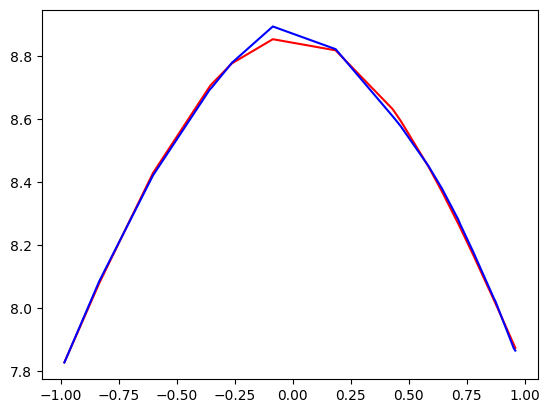

In [37]:
plt.plot(x, y_pred, c='red')
plt.plot(x, y_gyroid, c='blue')

## Exponential

In [94]:
class ExponentialModel(PolynomialModel):
    def __init__(self, data, *args, **kwargs):
        super().__init__(data, *args, **kwargs)

    def fit(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, 
                                                            self.y, test_size=self.test_size, 
                                                            random_state=self.random_state)
        self.model.fit(X_train, np.log(y_train))
        y_pred = np.exp(self.model.predict(X_test))
        y_hat = np.exp(self.model.predict(X_train))
        return {"r2_test": r2_score(y_test, y_pred), "r2_train": r2_score(y_train, y_hat), 
                "mse_test": mean_squared_error(y_test, y_pred), "mse_train": mean_squared_error(y_train, y_hat)}


    def return_formula(self):
        variables = self.model['features'].get_feature_names_out(['x']).tolist()
        coeffs = self.model['linear'].coef_
        coeffs_str = list(map(lambda x: str(round(x,2)), coeffs))
        polynomial = " + ".join([coef + var for coef, var in 
                                 zip(coeffs_str, variables) if np.abs(float(coef)) > self.round_for_poly])
        return f"{self.model['linear'].intercept_:.2f} * " + f"exp({polynomial})"

In [97]:
exponential_fit = np.polyfit(data_schwarz['x'].squeeze(), np.log(data_schwarz['y']), 2)
print(exponential_fit)

exponential_model_schwarz = ExponentialModel(data_schwarz)
exponential_model_schwarz.fit()


[ 0.02566328 -0.45120541  2.04445919]


'2.05 * exp(-0.38x + -0.13x^3 + 0.07x^4)'

In [87]:
#fit the model
x = x.squeeze()
y_schwarz = entropy_df['Schwarz'].values

exponential_fit = np.polyfit(x, np.log(y_schwarz), 2)

#view the output of the model
print(exponential_fit)

[ 0.02566328 -0.45120541  2.04445919]


In [10]:
exp_model = np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
#np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
#np.exp(exponential_fit[0] * x + exponential_fit[1]) 
mse(y_schwarz, exp_model)

0.023703962197357497

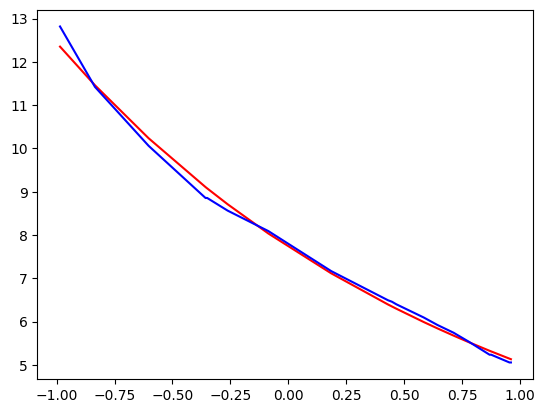

In [11]:
plt.plot(x, exp_model, c='red')
plt.plot(x, y_schwarz, c='blue')

In [12]:
y_gyroid = entropy_df['Gyroid'].values

exponential_fit = np.polyfit(x, np.log(y_gyroid), 2)
print(exponential_fit)

[-1.27552374e-01 -7.93674446e-04  2.17945386e+00]


In [13]:
exp_model = np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
#np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
#np.exp(exponential_fit[0] * x + exponential_fit[1]) 
#np.exp(x**2 * exponential_fit[0] + x * exponential_fit[1] + exponential_fit[2])
mse(y_gyroid, exp_model)

0.0003326615654946755

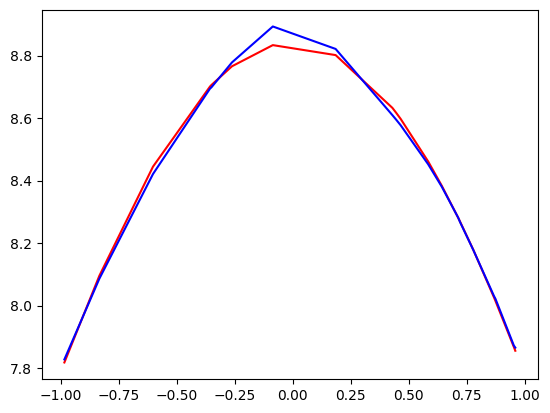

In [14]:
plt.plot(x, exp_model, c='red')
plt.plot(x, y_gyroid, c='blue')